In [1]:
import os
print(os.getcwd())  # Affiche le répertoire courant


c:\Users\jcluy\Python


In [2]:
import os

# Changer de répertoire
os.chdir("C:/Users/jcluy/Python/detection-anomalies-aws-mlflow")

# Vérifier qu'on est bien dans le bon dossier
print("Répertoire actuel :", os.getcwd())

Répertoire actuel : C:\Users\jcluy\Python\detection-anomalies-aws-mlflow


In [ ]:
from src.FonctionsPerso import *
import pandas as pd

# Définir le chemin proprement
base_dir = "C:/Users/jcluy/Python/detection-anomalies-aws-mlflow"
file_path = os.path.join(base_dir, "data", "raw", "creditcard.csv")

# Charger les données
df = pd.read_csv(file_path, sep=',')

# Vérifier le chargement
print(df.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

----------------------------------------------------------------------------------------------------
                               Informations sur le jeu de données
----------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14    

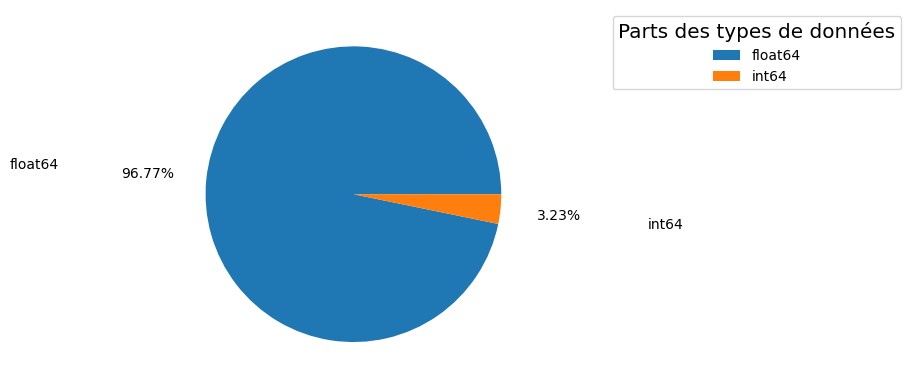

  
----------------------------------------------------------------------------------------------------


,Nombre de valeurs manquantes,Nombre de valeurs présentes,Taux de remplissage,Nombre de valeurs uniques,Doublons
Time,0,284807,100.0,124592,160215
V1,0,284807,100.0,275663,9144
V2,0,284807,100.0,275663,9144
V3,0,284807,100.0,275663,9144
V4,0,284807,100.0,275663,9144
V5,0,284807,100.0,275663,9144
V6,0,284807,100.0,275663,9144
V7,0,284807,100.0,275663,9144
V8,0,284807,100.0,275663,9144
V9,0,284807,100.0,275663,9144


In [7]:
afficher_informations_dataset(df)

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
